In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chi2_contingency

In [3]:
df = pd.read_csv('data/train_data.csv')
df.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,37765,15794860,Ch'eng,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,130453,15728005,Hargreaves,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,77297,15686810,Ts'ui,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,40858,15760244,Trevisano,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,19804,15810563,French,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


# Exploratory Data Analysis

## Checklist de base
### Analyse de Forme :
*   **variable target** : Exited
*   **lignes et colonnes** : 143579, 14
*   **types de variables** : 
    *   continues (6) : ID, CustomerId*, CreditScore, Age, Balance, EstimatedSalary
    *   discrètes (8): Surname, Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember, Exited
    *Colonne à supprimer car erreur dans le dataset (voir discord)
*   **Analyse des valeurs manquantes** : Aucune NaN
*   **Variables inutiles** : ID, CustomerId, Surname

### Analyse de Fond :
*   **Visualisation de la target** :
    -   21% de churn
*   **Signification des variables** :
    * Variables continues :
        - On distingue 2 groupes, Balance de compte à 0 et balance positive
    * Variables discrètes : 
        - Gender, HasCrCard, IsActiveMember, Exited sont binaires
        - La France représente plus de 50% du dataset
        - Il y a autant de membres actif que inactif
        - La proportion homme/femme semble équilibré
        - La grande majorité des clients ont 1 ou 2 produits
        - Les 3/4 des clients ont une carte de crédit
        - Moins de 1/4 des clients quittent la banque
        - La variable Tenure est bien répartit 
*   **Relation Variables / Target** :
    * Target / variables continues
        - L'âge semble être lié au churn, surtout apès 45 ans -> Hypothèse à tester
            - créé une colonne 'AgeGroup'
                - Le churn augmente de 45 à 55 ans et retombe après 60 ans
                    - 18–39 ans → churn faible (<15%).
                    - 40–44 ans → premier saut (~31%).
                    - 45–49 ans → énorme (~53%).
                    - 50–54 ans → encore plus haut (~64%).
                    - 55–59 ans → un peu moins (~55%).
                    - 60+ ans → retombe (~31%).
        - Balance = 0 (54% des clients, churn ~16%) vs Balance > 0 (46% des clients, churn ~27%) → Hypothèse à tester
            - créé une colonne 'HasBalance' binaire
    * Target / variables discrètes
        - La France et l'Espagne ont un taux de churn équivalent d'environ 17% (allemenagne -> 38 %) → Hypothèse à tester
            - créé 'IsGerman' binaire semble pertinente vu la ressemblance entre la France et l'Espagne
        - Les femmes churn plus que les hommes (28% vs 16%) → Hypothèse à tester
        - Les clients avec 2 produits sont très fidèles (6% de churn), avec 1 produit (34% de churn) et pour 3 et 4 produits (87% de churn)
            - créé 'NumProductsGroup' 1, 2 ou 3+
        - Les clients inactifs churn plus (30% vs 12%) → Hypothèse à tester
    * Balance / Age
    * Balance / Genre
    * Balance / IsActiveMember
    * Age / Genre
    * IsGerman + Gender
    * IsActiveMember + HasCrCard
    * Balance / EstimatedSalary
    * Age / Tenure
    * creditScore / AgeGroup
    * Balance / Tenure

### **Test d'hypothèses :**

* Hypothèses nulle (H0):
    - La variable 'AgeGroup' est indépendante de la variable 'Exited'
    - La variable 'HasBalance' est indépendante de la variable 'Exited'
    - La variable 'IsGerman' est indépendante de la variable 'Exited'
    - La variable 'Genre' est indépendante de la variable 'Exited'
    - La variable 'NumProductsGroup' est indépendante de la variable 'Exited'
    - La variable 'IsActiveMember' est indépendante de la variable 'Exited'

### **Conclusion EDA :**
Les principales variables explicatives du churn semblent être l’**âge** (surtout 45–55 ans), la **balance** (0 vs >0), la **géographie** (spécifiquement l’Allemagne), le **genre**, le **nombre de produits** et l’**activité du client**.
Certaines variables (CreditScore, Salary, Tenure) n’ont pas montré de relation claire avec la target.
Les insights obtenus motivent la création de **nouvelles features** (**AgeGroup**, **HasBalance**, **IsGerman**, **NumProductsGroup**) qui seront intégrées dans le pipeline de modélisation.

In [4]:
var_continues = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
var_discretes = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember','Exited']

### **Analyse de la forme des données**

In [5]:
df.shape

(143579, 14)

In [6]:
df.nunique().sort_values()

Gender                  2
Exited                  2
HasCrCard               2
IsActiveMember          2
Geography               3
NumOfProducts           4
Tenure                 11
Age                    71
CreditScore           456
Surname              2765
CustomerId          22017
Balance             27258
EstimatedSalary     50076
ID                 143579
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143579 entries, 0 to 143578
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               143579 non-null  int64  
 1   CustomerId       143579 non-null  int64  
 2   Surname          143579 non-null  object 
 3   CreditScore      143579 non-null  int64  
 4   Geography        143579 non-null  object 
 5   Gender           143579 non-null  object 
 6   Age              143579 non-null  float64
 7   Tenure           143579 non-null  int64  
 8   Balance          143579 non-null  float64
 9   NumOfProducts    143579 non-null  int64  
 10  HasCrCard        143579 non-null  float64
 11  IsActiveMember   143579 non-null  float64
 12  EstimatedSalary  143579 non-null  float64
 13  Exited           143579 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 15.3+ MB


In [8]:
df.dtypes.value_counts()

int64      6
float64    5
object     3
Name: count, dtype: int64

<Axes: >

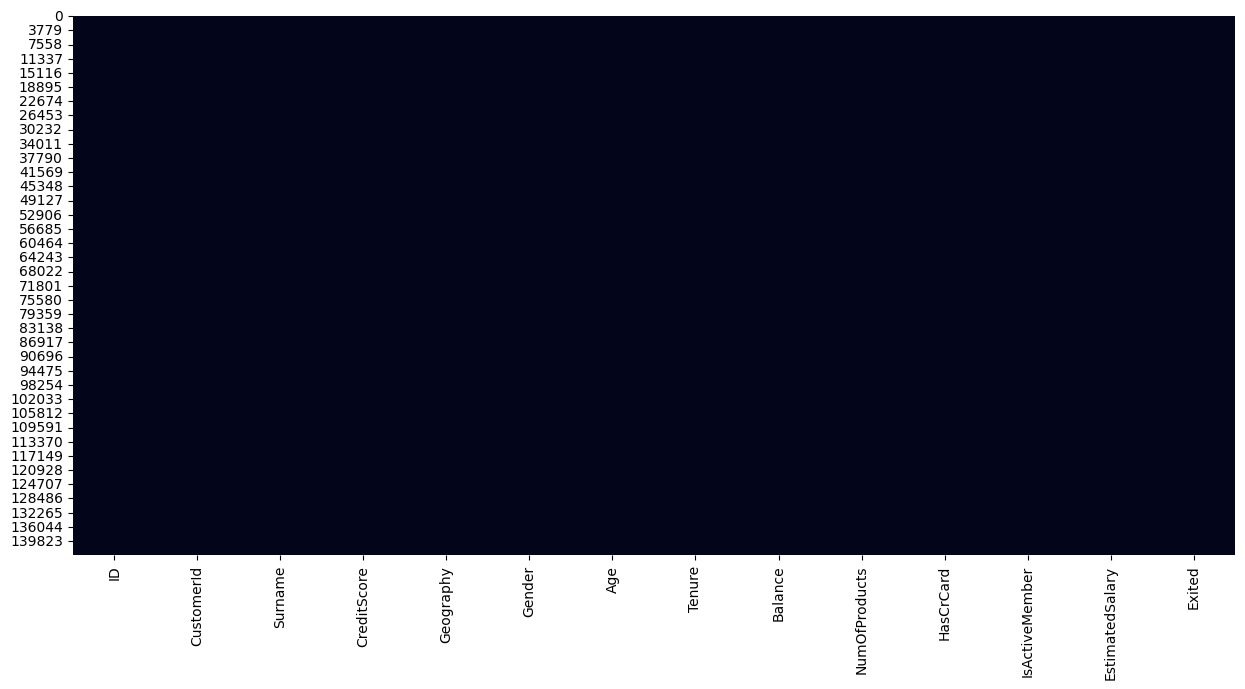

In [9]:
plt.figure(figsize=(15,7))
sns.heatmap(df.isna(), cbar=False)

In [10]:
df.isna().sum()

ID                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### **Analyse de Fond**

1. Visualisation initiale - Elimination des colonnes inutiles


In [11]:
df = df.drop('CustomerId', axis=1)
df = df.drop('ID', axis=1)
df = df.drop('Surname', axis=1)

In [12]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


### **Examen de la colonne target**

In [13]:
df['Exited'].value_counts(normalize=True)

Exited
0    0.787922
1    0.212078
Name: proportion, dtype: float64

### **Histogrammes des variables continues**

In [14]:
def displot(df, variable):
    fig, ax = plt.subplots(2,1, sharex=True)
    sns.histplot(data=df, x=variable, ax=ax[0])
    sns.boxplot(data=df, x=variable, ax=ax[1])
    plt.suptitle(f"Répartition de la variable '{variable}' dans ce jeu de donnée")

In [15]:
var_continues

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

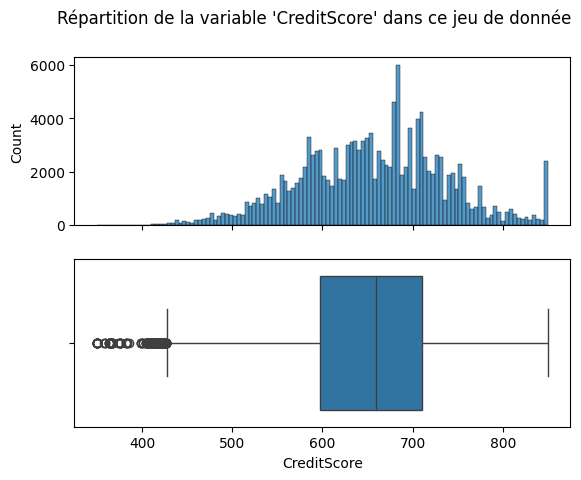

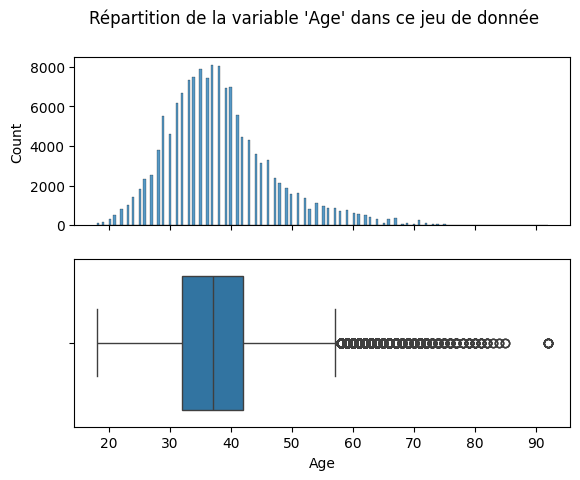

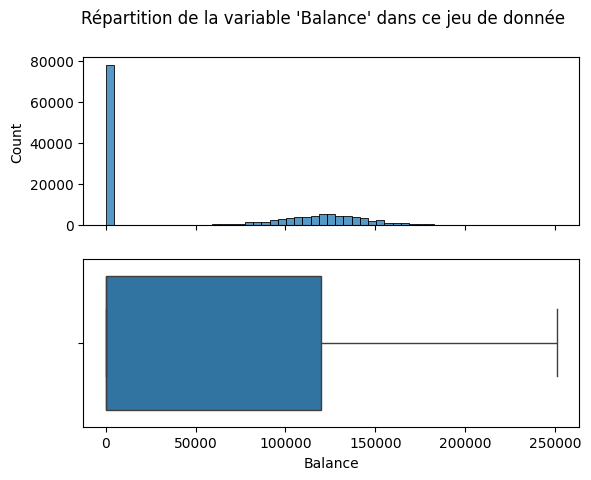

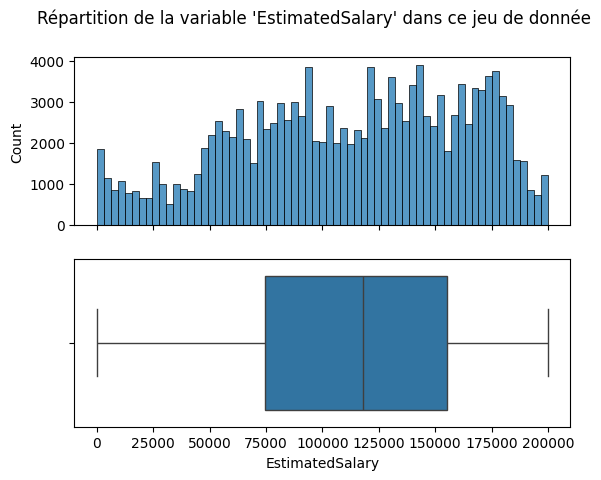

In [16]:
for variable in var_continues:
    displot(df, variable)

### **Variables discrètes**

In [17]:
var_discretes

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'Exited']

In [18]:
for variable in var_discretes:
    print(f'{variable:-<20} {df[variable].unique()}')

Geography----------- ['France' 'Germany' 'Spain']
Gender-------------- ['Male' 'Female']
Tenure-------------- [ 7  2  5  1  9  8  4  0  3  6 10]
NumOfProducts------- [1 2 3 4]
HasCrCard----------- [1. 0.]
IsActiveMember------ [1. 0.]
Exited-------------- [0 1]


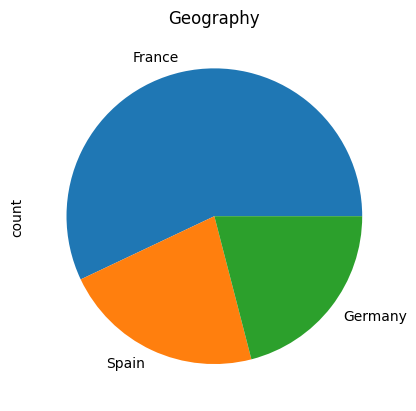

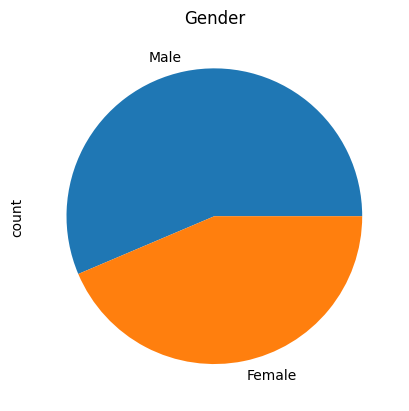

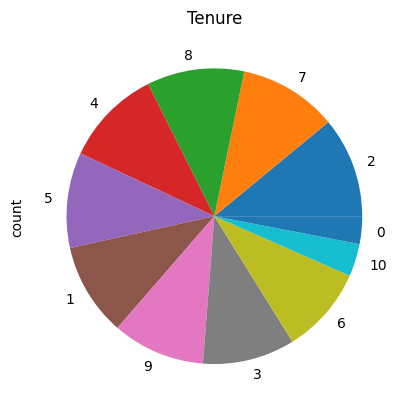

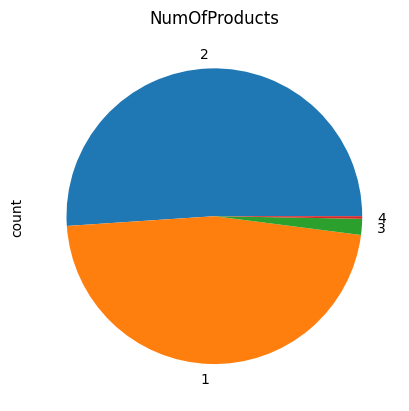

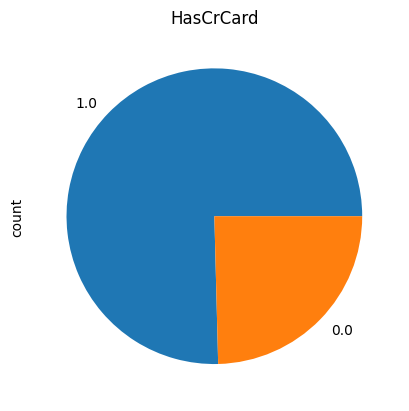

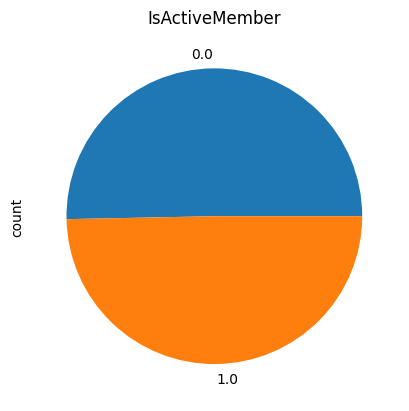

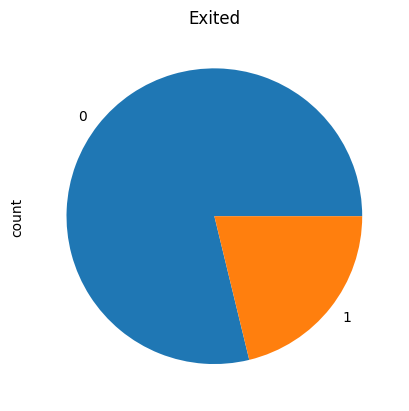

In [19]:
for variable in var_discretes:
    plt.figure()
    df[variable].value_counts().plot.pie()
    plt.title(variable)

### **Relation Target / Variables**
#### Création de sous-ensembles churn(1) et non-churn(0)

In [20]:
churn_df = df[df['Exited'] == 1]
no_churn_df = df[df['Exited'] == 0]

### Target / variables discrètes

In [21]:
var_discretes

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'Exited']

### Target / Geography

In [22]:
pd.crosstab(df["Exited"], df['Geography'], normalize='columns')

Geography,France,Germany,Spain
Exited,,,
0,0.83455,0.619731,0.827339
1,0.16545,0.380269,0.172661


In [23]:
df['Geography'].value_counts()

Geography
France     81886
Spain      31588
Germany    30105
Name: count, dtype: int64

Text(0.5, 0.98, 'Répartition géographique du churn dans ce jeu de donnée')

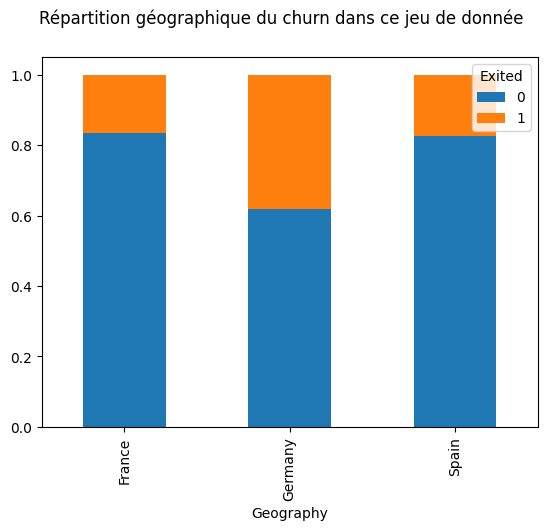

In [24]:
pd.crosstab(df["Geography"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition géographique du churn dans ce jeu de donnée")

In [25]:
df['IsGerman'] = (df['Geography'] == 'Germany').astype(int)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsGerman
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0,0
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0,0
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0,0
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1,1
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0,0


In [26]:
pd.crosstab(df["Exited"], df['IsGerman'], normalize='columns')

IsGerman,0,1
Exited,,
0,0.832543,0.619731
1,0.167457,0.380269


Text(0.5, 0.98, 'Répartition isGerman du churn dans ce jeu de donnée')

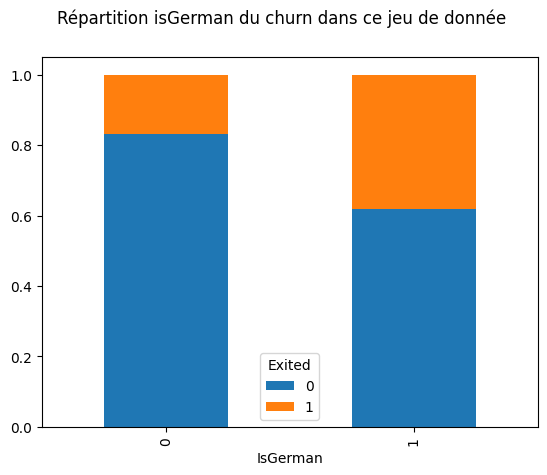

In [27]:
pd.crosstab(df["IsGerman"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition isGerman du churn dans ce jeu de donnée")

### Target / Gender

In [28]:
pd.crosstab(df["Exited"], df['Gender'], normalize='columns')

Gender,Female,Male
Exited,,
0,0.719307,0.840983
1,0.280693,0.159017


Text(0.5, 0.98, 'Répartition par genre du churn dans ce jeu de donnée')

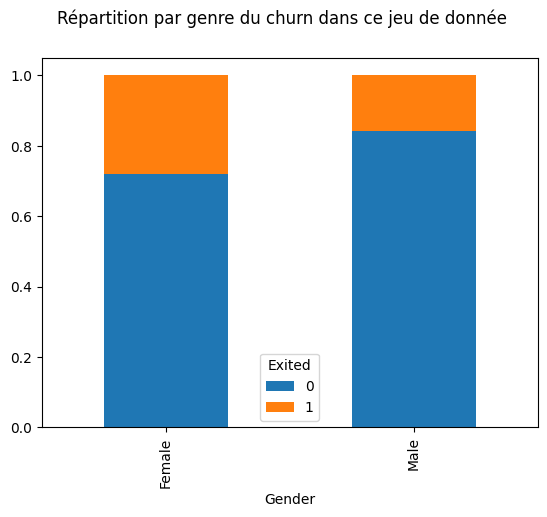

In [29]:
pd.crosstab(df["Gender"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition par genre du churn dans ce jeu de donnée")

### Target / Tenure

In [30]:
pd.crosstab(df["Exited"], df['Tenure'], normalize='columns')

Tenure,0,1,2,3,4,5,6,7,8,9,10
Exited,,,,,,,,,,,
0,0.744133,0.772512,0.805023,0.771265,0.772563,0.779832,0.802712,0.811684,0.800223,0.787662,0.785547
1,0.255867,0.227488,0.194977,0.228735,0.227437,0.220168,0.197288,0.188316,0.199777,0.212338,0.214453


Text(0.5, 0.98, 'Répartition Tenure du churn dans ce jeu de donnée')

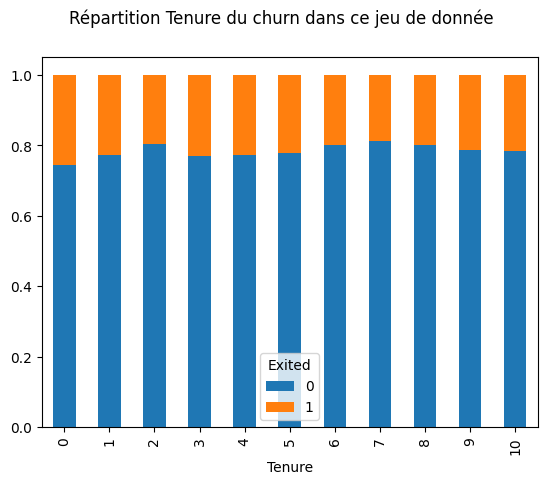

In [31]:
pd.crosstab(df["Tenure"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition Tenure du churn dans ce jeu de donnée")

### Target / NumOfProducts

In [32]:
pd.crosstab(df["Exited"], df['NumOfProducts'], normalize='columns')

NumOfProducts,1,2,3,4
Exited,,,,
0,0.651758,0.939673,0.116335,0.131188
1,0.348242,0.060327,0.883665,0.868812


Text(0.5, 0.98, 'Répartition NumOfProducts du churn dans ce jeu de donnée')

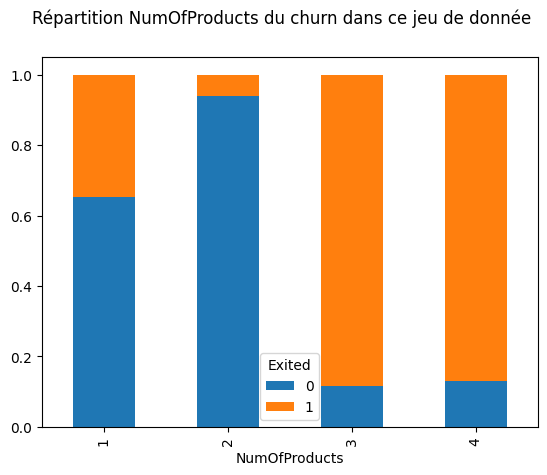

In [33]:
pd.crosstab(df["NumOfProducts"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition NumOfProducts du churn dans ce jeu de donnée")

In [34]:
import numpy as np

df["NumProductsGroup"] = np.where(df["NumOfProducts"] == 1, "1",
                         np.where(df["NumOfProducts"] == 2, "2", "3+"))
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsGerman,NumProductsGroup
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0,0,1
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0,0,2
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0,0,2
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1,1,3+
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,559,Germany,Male,45.0,3,111634.29,1,1.0,1.0,103349.74,0,1,1
143575,597,Germany,Male,41.0,10,119182.73,1,0.0,0.0,121299.14,0,1,1
143576,576,Spain,Male,31.0,6,127299.56,1,1.0,1.0,57569.89,0,0,1
143577,751,France,Female,27.0,4,90721.11,1,0.0,0.0,84496.78,0,0,1


### Target / HasCrCard

In [35]:
pd.crosstab(df["Exited"], df['HasCrCard'], normalize='columns')

HasCrCard,0.0,1.0
Exited,,
0,0.771732,0.793201
1,0.228268,0.206799


<Axes: xlabel='HasCrCard'>

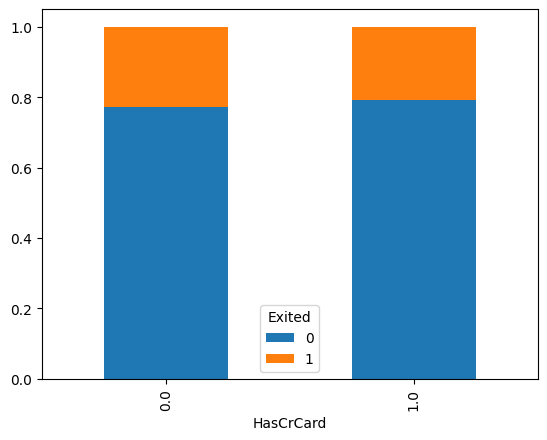

In [36]:
pd.crosstab(df["HasCrCard"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)

### Target / IsActiveMember

In [37]:
pd.crosstab(df["Exited"], df['IsActiveMember'], normalize='columns')

IsActiveMember,0.0,1.0
Exited,,
0,0.702321,0.874625
1,0.297679,0.125375


Text(0.5, 0.98, 'Répartition IsActiveMember du churn dans ce jeu de donnée')

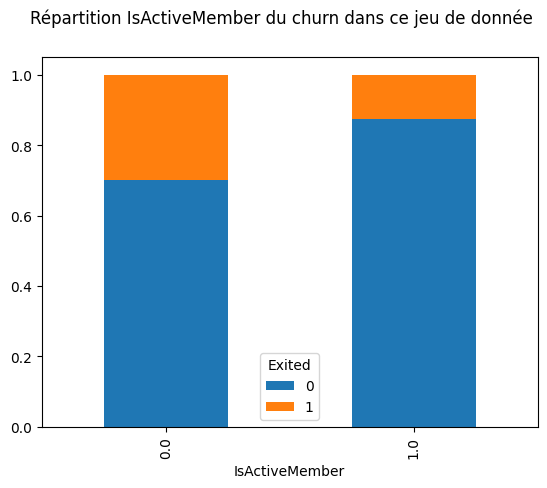

In [38]:
pd.crosstab(df["IsActiveMember"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition IsActiveMember du churn dans ce jeu de donnée")

### Target / variables continues

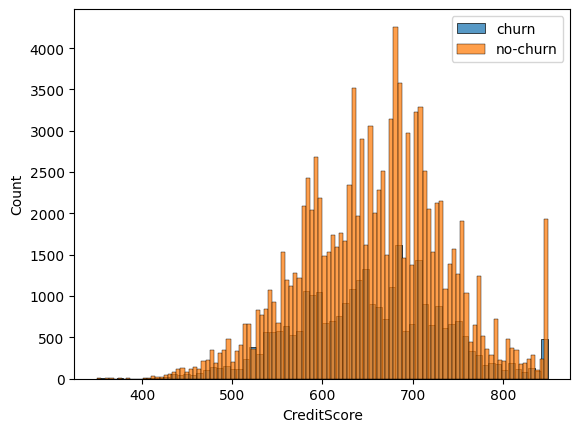

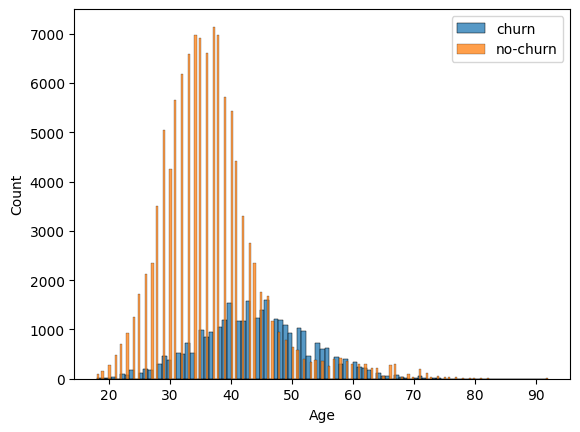

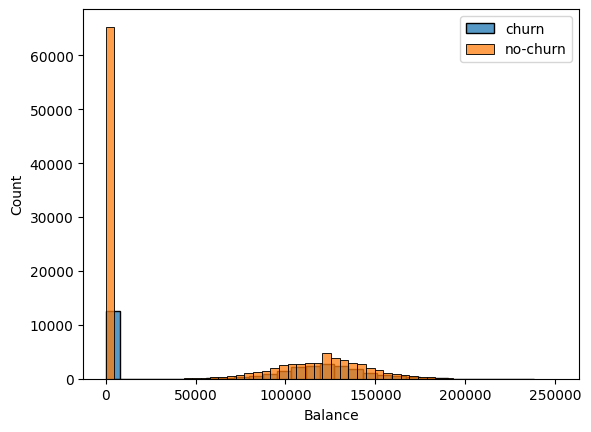

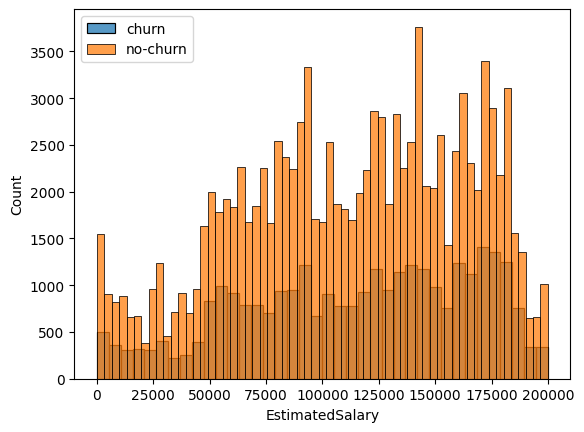

In [39]:
for col in var_continues:
    plt.figure()
    sns.histplot(churn_df[col], label='churn')
    sns.histplot(no_churn_df[col], label='no-churn')
    plt.legend()

### Relation Target / Balance

In [40]:
df['HasBalance'] = (df['Balance'] > 0).astype(int)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsGerman,NumProductsGroup,HasBalance
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0,0,1,1
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0,0,2,0
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0,0,2,0
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1,1,3+,1
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,559,Germany,Male,45.0,3,111634.29,1,1.0,1.0,103349.74,0,1,1,1
143575,597,Germany,Male,41.0,10,119182.73,1,0.0,0.0,121299.14,0,1,1,1
143576,576,Spain,Male,31.0,6,127299.56,1,1.0,1.0,57569.89,0,0,1,1
143577,751,France,Female,27.0,4,90721.11,1,0.0,0.0,84496.78,0,0,1,1


In [41]:
pd.crosstab(df["Exited"], df['HasBalance'], normalize='columns')

HasBalance,0,1
Exited,,
0,0.838394,0.728027
1,0.161606,0.271973


Text(0.5, 0.98, 'Répartition HasBalance du churn dans ce jeu de donnée')

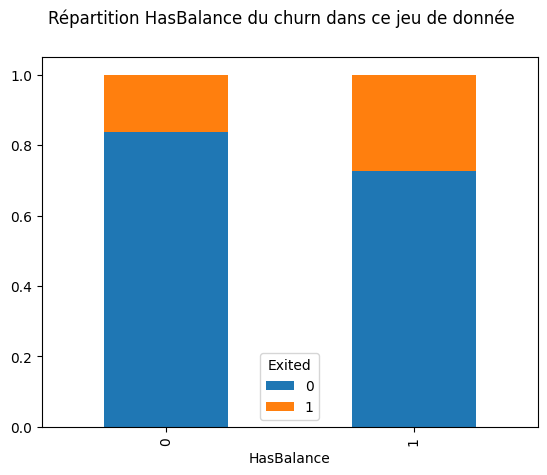

In [42]:
pd.crosstab(df["HasBalance"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition HasBalance du churn dans ce jeu de donnée")

### Relation Target / variables AgeGroup

In [43]:
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[18, 30, 35, 40, 45, 50, 55, 60, 100],
    labels=["18-29", "30-34", "35-39", "40-44", "45-49","50-54", "55-59", "60+"]
)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsGerman,NumProductsGroup,HasBalance,AgeGroup
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0,0,1,1,18-29
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0,0,2,0,30-34
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0,0,2,0,35-39
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1,1,3+,1,55-59
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0,0,2,0,30-34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,559,Germany,Male,45.0,3,111634.29,1,1.0,1.0,103349.74,0,1,1,1,40-44
143575,597,Germany,Male,41.0,10,119182.73,1,0.0,0.0,121299.14,0,1,1,1,40-44
143576,576,Spain,Male,31.0,6,127299.56,1,1.0,1.0,57569.89,0,0,1,1,30-34
143577,751,France,Female,27.0,4,90721.11,1,0.0,0.0,84496.78,0,0,1,1,18-29


In [44]:
pd.crosstab(df["Exited"], df['AgeGroup'], normalize='columns')

AgeGroup,18-29,30-34,35-39,40-44,45-49,50-54,55-59,60+
Exited,,,,,,,,
0,0.916972,0.908342,0.851535,0.689557,0.46562,0.355218,0.448483,0.691407
1,0.083028,0.091658,0.148465,0.310443,0.53438,0.644782,0.551517,0.308593


Text(0.5, 0.98, 'Répartition AgeGroup du churn dans ce jeu de donnée')

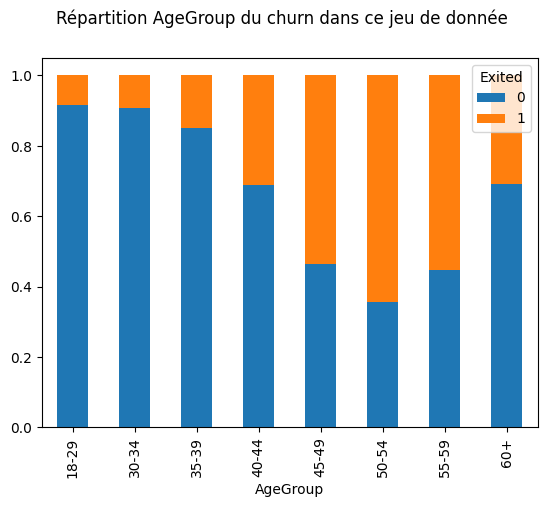

In [45]:
pd.crosstab(df["AgeGroup"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition AgeGroup du churn dans ce jeu de donnée")

## Test d'hypothèses

* Hypothèses nulle (H0):
    - La variable 'AgeGroup' est indépendante de la variable 'Exited'
    - La variable 'HasBalance' est indépendante de la variable 'Exited'
    - La variable 'IsGerman' est indépendante de la variable 'Exited'
    - La variable 'Gender' est indépendante de la variable 'Exited'
    - La variable 'NumProductsGroup' est indépendante de la variable 'Exited'
    - La variable 'IsActiveMember' est indépendante de la variable 'Exited'

In [46]:
def test_ki2_contingency(var_1, var_2):
    H0 = f"H0 : \"La variable '{var_1}' est indépendante de la variable '{var_2}'\""
    print(H0)

    alpha = 0.02

    contingency_table = pd.crosstab(df[var_1], df[var_2])
    p_value = chi2_contingency(contingency_table).pvalue

    if p_value < alpha:
        print(p_value)
        print("Nous avons suffisament d'évidences pour rejeter H0\n")
        
    else :
        print(p_value)
        print("Nous n'avons pas suffisament d'évidences pour rejeter H0\n")

In [94]:
from scipy.stats import ttest_ind

def test_student_2_grp_ind(var_2):
    H0 = f"H0 : \"La variable 'Exited' est indépendante de la variable '{var_2}'\""
    print(H0)

    alpha = 0.02

    df_churn = df.query("Exited == 1")
    df_no_churn = df.query("Exited == 0")
    p_value = ttest_ind(df_churn[var_2], df_no_churn[var_2]).pvalue

    if p_value < alpha:
        print(p_value)
        print("Nous avons suffisament d'évidences pour rejeter H0\n")
        
    else :
        print(p_value)
        print("Nous n'avons pas suffisament d'évidences pour rejeter H0\n")

In [47]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsGerman,NumProductsGroup,HasBalance,AgeGroup
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0,0,1,1,18-29
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0,0,2,0,30-34
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0,0,2,0,35-39
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1,1,3+,1,55-59
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0,0,2,0,30-34


H0 : "La variable 'AgeGroup' est indépendante de la variable 'Exited'"

In [95]:
test_ki2_contingency('AgeGroup', 'Exited')
test_ki2_contingency('HasBalance', 'Exited')
test_ki2_contingency('IsGerman', 'Exited')
test_ki2_contingency('Gender', 'Exited')
test_ki2_contingency('NumProductsGroup', 'Exited')
test_ki2_contingency('IsActiveMember', 'Exited')
test_ki2_contingency('HasCrCard', 'Exited')
test_ki2_contingency('Tenure', 'Exited')
test_student_2_grp_ind('EstimatedSalary')
test_student_2_grp_ind('CreditScore')

H0 : "La variable 'AgeGroup' est indépendante de la variable 'Exited'"
0.0
Nous avons suffisament d'évidences pour rejeter H0

H0 : "La variable 'HasBalance' est indépendante de la variable 'Exited'"
0.0
Nous avons suffisament d'évidences pour rejeter H0

H0 : "La variable 'IsGerman' est indépendante de la variable 'Exited'"
0.0
Nous avons suffisament d'évidences pour rejeter H0

H0 : "La variable 'Gender' est indépendante de la variable 'Exited'"
0.0
Nous avons suffisament d'évidences pour rejeter H0

H0 : "La variable 'NumProductsGroup' est indépendante de la variable 'Exited'"
0.0
Nous avons suffisament d'évidences pour rejeter H0

H0 : "La variable 'IsActiveMember' est indépendante de la variable 'Exited'"
0.0
Nous avons suffisament d'évidences pour rejeter H0

H0 : "La variable 'HasCrCard' est indépendante de la variable 'Exited'"
1.1107552844464458e-17
Nous avons suffisament d'évidences pour rejeter H0

H0 : "La variable 'Tenure' est indépendante de la variable 'Exited'"
1.292838

## Etude des profils économes et dépensiers

In [49]:
df['ratioDepense'] = df.query("Balance > 50000")["Balance"] / ((df['Tenure'] * df.query('EstimatedSalary > 75000')['EstimatedSalary']) + 1e-5)
df['ratioDepense'] = df['ratioDepense'].fillna(0)

<Axes: xlabel='Exited'>

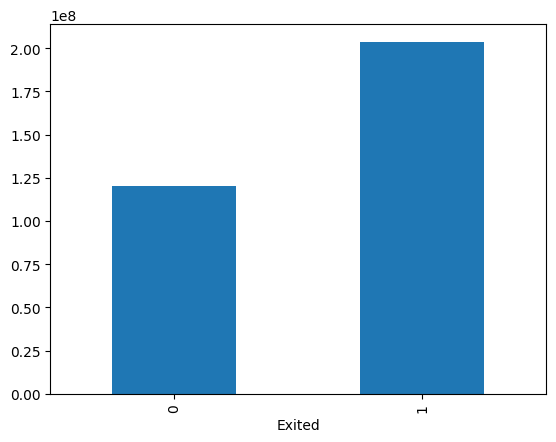

In [50]:
df.groupby('Exited')['ratioDepense'].mean().plot(kind='bar')

In [51]:
seuil = df["ratioDepense"].median()
df["isSpender"] = (df["ratioDepense"] > seuil).astype(int)


In [52]:
pd.crosstab(df["isSpender"], df["Exited"], normalize="index")

Exited,0,1
isSpender,,
0,0.819847,0.180153
1,0.725848,0.274152


Text(0.5, 0.98, 'Répartition isSpender du churn dans ce jeu de donnée')

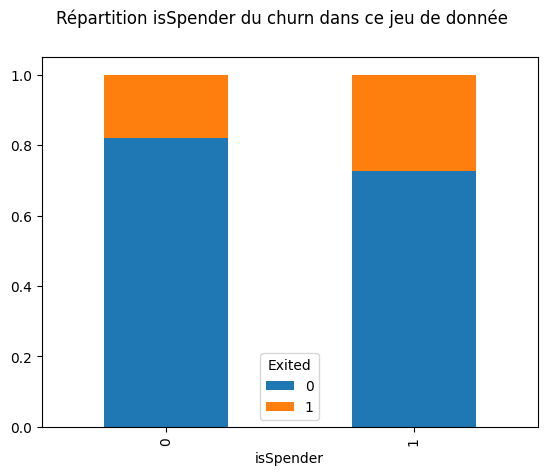

In [53]:
pd.crosstab(df["isSpender"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition isSpender du churn dans ce jeu de donnée")

Text(0.5, 0.98, "Répartition de la variable ''Balance'' dans ce jeu de donnée")

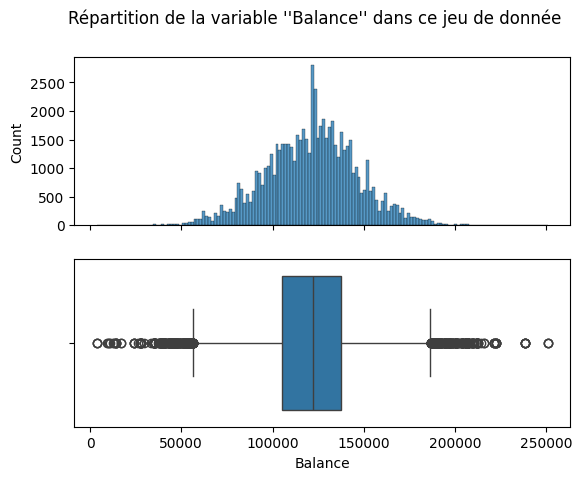

In [54]:
fig, ax = plt.subplots(2,1, sharex=True)
sns.histplot(data=df.query('Balance > 0'), x='Balance', ax=ax[0])
sns.boxplot(data=df.query('Balance > 0'), x='Balance', ax=ax[1])
plt.suptitle(f"Répartition de la variable ''Balance'' dans ce jeu de donnée")

In [55]:
bins = [-1, 0, 50000, 100000, 150000, 200000, df["Balance"].max()]
labels = ["Nulle", "Faible", "Moyen", "Normal", "Élevé", "Très élevé"]

df["BalanceCat"] = pd.cut(df["Balance"], bins=bins, labels=labels)


In [56]:
pd.crosstab(df["BalanceCat"], df["Exited"], normalize="index")

Exited,0,1
BalanceCat,,
Nulle,0.838394,0.161606
Faible,0.693642,0.306358
Moyen,0.780299,0.219701
Normal,0.708536,0.291464
Élevé,0.759446,0.240554
Très élevé,0.684211,0.315789


Text(0.5, 0.98, 'Répartition BalanceCat du churn dans ce jeu de donnée')

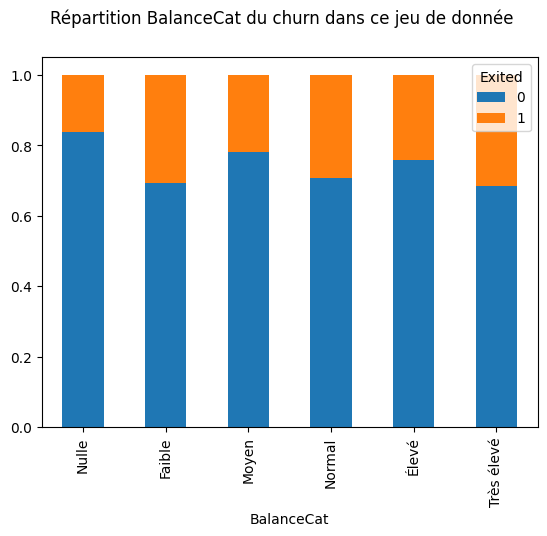

In [57]:
pd.crosstab(df["BalanceCat"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition BalanceCat du churn dans ce jeu de donnée")

### hypothèses

In [58]:
test_ki2_contingency('BalanceCat', 'Exited')

H0 : "La variable 'BalanceCat' est indépendante de la variable 'Exited'"
0.0
Nous avons suffisament d'évidences pour rejeter H0



In [59]:
df["Tenure_low_card"] = ((df["Tenure"] < 1) & (df["HasCrCard"] == 1)).astype(int)


In [60]:
pd.crosstab(df["Tenure_low_card"], df["Exited"], normalize="index")

Exited,0,1
Tenure_low_card,,
0,0.788569,0.211431
1,0.758929,0.241071


In [61]:
test_ki2_contingency('Tenure_low_card', 'Exited')

H0 : "La variable 'Tenure_low_card' est indépendante de la variable 'Exited'"
6.500599805681371e-05
Nous avons suffisament d'évidences pour rejeter H0



df

In [62]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsGerman,NumProductsGroup,HasBalance,AgeGroup,ratioDepense,isSpender,BalanceCat,Tenure_low_card
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0,0,1,1,18-29,0.116705,1,Normal,0
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0,0,2,0,30-34,0.000000,0,Nulle,0
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0,0,2,0,35-39,0.000000,0,Nulle,0
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1,1,3+,1,55-59,0.000000,0,Normal,0
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0,0,2,0,30-34,0.000000,0,Nulle,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,559,Germany,Male,45.0,3,111634.29,1,1.0,1.0,103349.74,0,1,1,1,40-44,0.360053,1,Normal,0
143575,597,Germany,Male,41.0,10,119182.73,1,0.0,0.0,121299.14,0,1,1,1,40-44,0.098255,1,Normal,0
143576,576,Spain,Male,31.0,6,127299.56,1,1.0,1.0,57569.89,0,0,1,1,30-34,0.000000,0,Normal,0
143577,751,France,Female,27.0,4,90721.11,1,0.0,0.0,84496.78,0,0,1,1,18-29,0.268416,1,Moyen,0


In [63]:
df["test"] = ((df["CreditScore"]) * (df["IsActiveMember"])).astype(int)


<Axes: xlabel='Exited'>

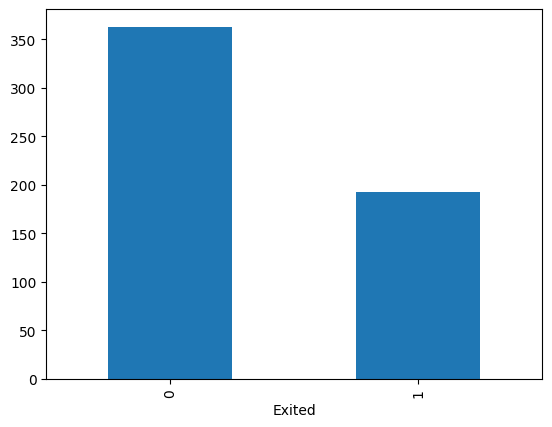

In [64]:
df.groupby('Exited')['test'].mean().plot(kind='bar')

<Axes: xlabel='Exited'>

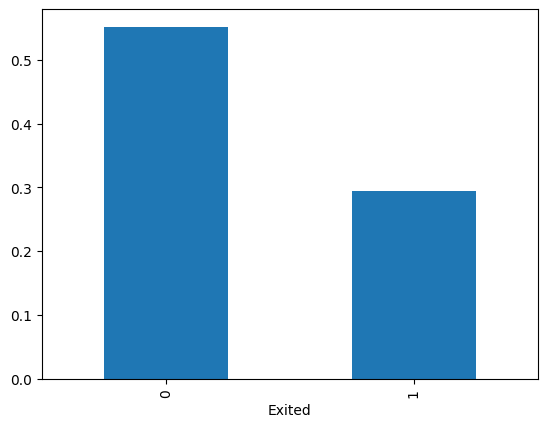

In [65]:
df.groupby('Exited')['IsActiveMember'].mean().plot(kind='bar')

### Age Over 45

In [66]:
df["AgeOver39"] = (df["Age"] > 39).astype(int)

In [67]:
df.groupby('Exited')['AgeOver39'].describe()

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,0.278151,0.448090,0.0,0.0,0.0,1.0,1.0
1,30450.0,0.692282,0.461557,0.0,0.0,1.0,1.0,1.0


<Axes: xlabel='Exited'>

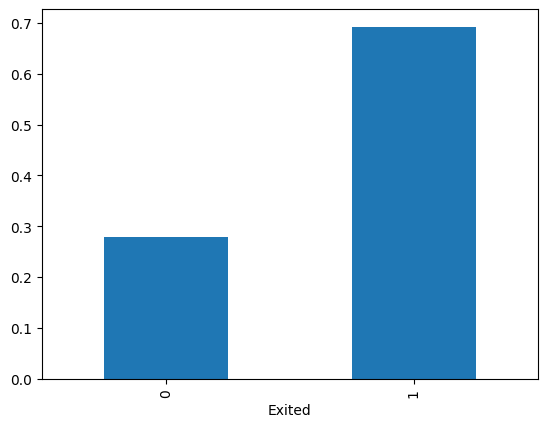

In [68]:
df.groupby('Exited')['AgeOver39'].mean().plot(kind='bar')

In [69]:
ageChurnOpti = 0
bestDiff = 0

for age in range(30, 60):
    df["AgeOver"] = (df["Age"] > age).astype(int)

    # Proportion de churners et non-churners au-dessus du seuil
    churn_mean = df.query("Exited == 1")["AgeOver"].mean()
    no_churn_mean = df.query("Exited == 0")["AgeOver"].mean()

    # Différence absolue entre churn et no-churn
    diff = abs(churn_mean - no_churn_mean)

    if diff > bestDiff:
        bestDiff = diff
        ageChurnOpti = age

print(f"Seuil optimal : {ageChurnOpti}, Différence = {bestDiff:.4f}")


Seuil optimal : 39, Différence = 0.4141


### NumberOfProductGroup vs Genre
Le taux d'hommes et de femmes churnant est identique dans les 3 groupes

Text(0.5, 0.98, 'Répartition BalanceCat du churn dans ce jeu de donnée')

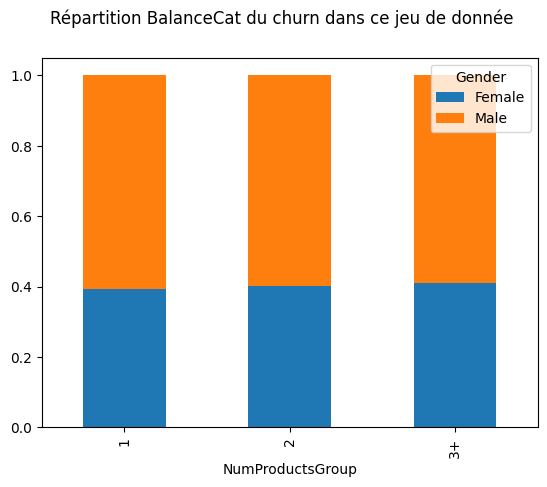

In [70]:
pd.crosstab(df.query('Exited == 0')["NumProductsGroup"], df["Gender"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition BalanceCat du churn dans ce jeu de donnée")

### Geography vs Genre
Le taux d'hommes et de femmes churnant est indépendant de la Geography

Text(0.5, 0.98, 'Répartition BalanceCat du churn dans ce jeu de donnée')

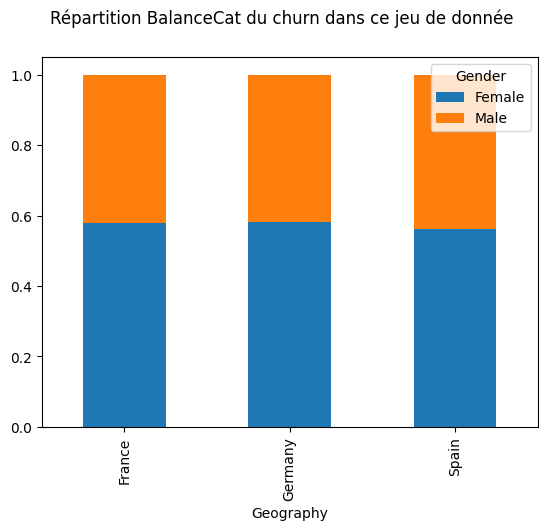

In [71]:
pd.crosstab(df.query('Exited == 1')["Geography"], df["Gender"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition BalanceCat du churn dans ce jeu de donnée")

### Genre vs Age
« Le churn intervient en moyenne au même âge chez les hommes et chez les femmes. »

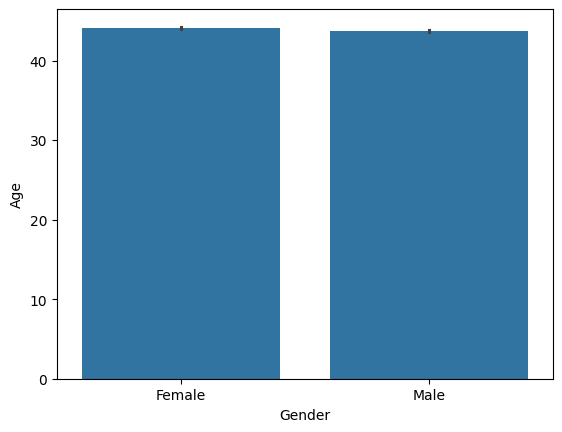

In [72]:
sns.barplot(data=df.query("Exited == 1"), x="Gender", y="Age", estimator="mean")
plt.show()

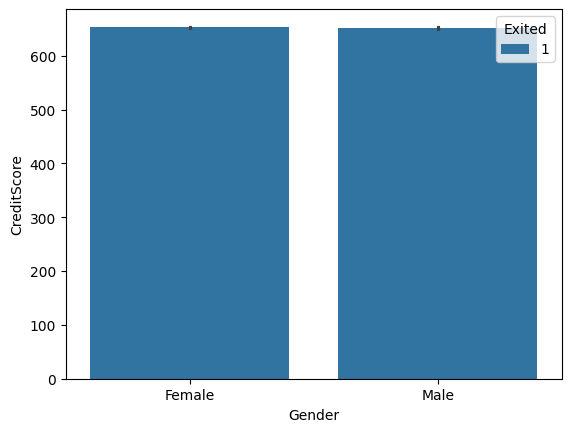

In [73]:
sns.barplot(data=df.query("Exited == 1"), x="Gender", y="CreditScore", hue="Exited", estimator="mean")
plt.show()

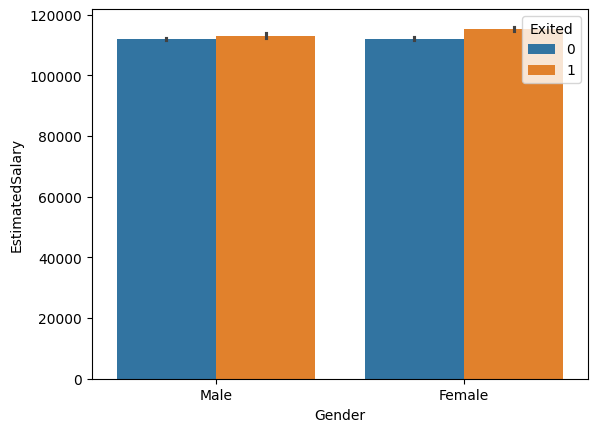

In [74]:
sns.barplot(data=df, x="Gender", y="EstimatedSalary", hue="Exited", estimator="mean")
plt.show()

In [75]:
df.query("Exited == 1 and Gender == 'Male'").groupby("Exited")["EstimatedSalary"].mean()


Exited
1    113122.153645
Name: EstimatedSalary, dtype: float64

In [76]:
df.query("Exited == 0 and Gender == 'Male'").groupby("Exited")["EstimatedSalary"].mean()

Exited
0    111968.019988
Name: EstimatedSalary, dtype: float64

In [77]:
df.query("Exited == 1 and Gender == 'Female'").groupby("Exited")["EstimatedSalary"].mean()

Exited
1    115353.348198
Name: EstimatedSalary, dtype: float64

In [78]:
df.query("Exited == 0 and Gender == 'Female'").groupby("Exited")["EstimatedSalary"].mean()

Exited
0    112108.841482
Name: EstimatedSalary, dtype: float64

In [79]:
df["SalaryBin"] = pd.qcut(df["EstimatedSalary"], q=10)  # déciles
churn_rate = df.groupby("SalaryBin")["Exited"].mean()
print(churn_rate)


SalaryBin
(11.579, 44965.44]        0.198248
(44965.44, 64584.278]     0.221075
(64584.278, 83022.66]     0.196393
(83022.66, 98661.27]      0.201044
(98661.27, 117931.1]      0.206063
(117931.1, 132424.69]     0.205676
(132424.69, 146680.23]    0.216403
(146680.23, 162879.22]    0.214947
(162879.22, 176791.27]    0.234192
(176791.27, 199992.48]    0.226804
Name: Exited, dtype: float64


/tmp/ipykernel_3052/357751070.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = df.groupby("SalaryBin")["Exited"].mean()


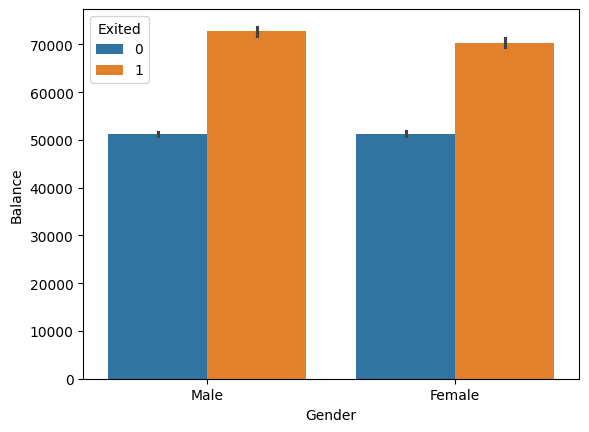

In [80]:
sns.barplot(data=df, x="Gender", y="Balance", hue="Exited", estimator="mean")
plt.show()

Text(0.5, 0.98, 'Répartition BalanceCat du churn dans ce jeu de donnée')

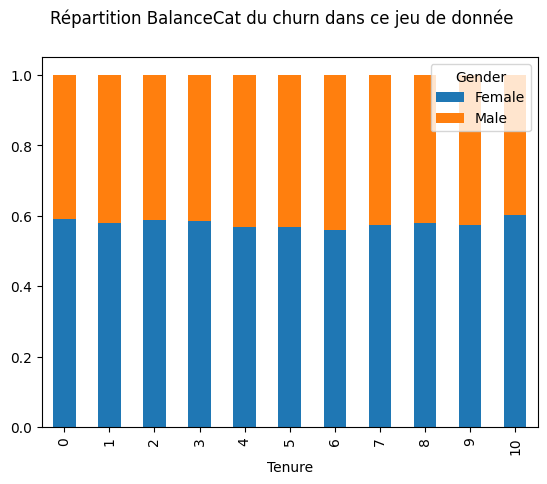

In [81]:
pd.crosstab(df.query('Exited == 1')["Tenure"], df["Gender"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition BalanceCat du churn dans ce jeu de donnée")

Text(0.5, 0.98, 'Répartition BalanceCat du churn dans ce jeu de donnée')

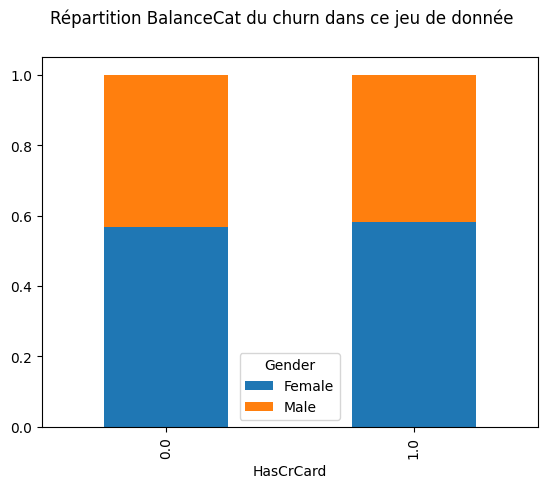

In [82]:
pd.crosstab(df.query('Exited == 1')["HasCrCard"], df["Gender"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition BalanceCat du churn dans ce jeu de donnée")

Text(0.5, 0.98, 'Répartition BalanceCat du churn dans ce jeu de donnée')

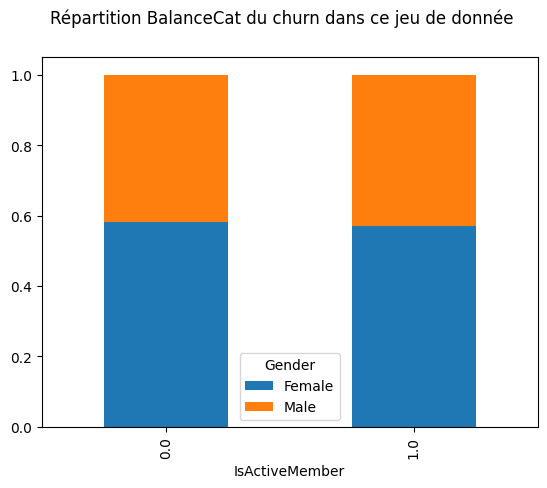

In [83]:
pd.crosstab(df.query('Exited == 1')["IsActiveMember"], df["Gender"], normalize="index").plot(kind="bar", stacked=True)
plt.suptitle("Répartition BalanceCat du churn dans ce jeu de donnée")

In [84]:
df["is_young_high_income"] = (df["Age"] < 30) & (df["EstimatedSalary"] > 100000)

<Axes: xlabel='is_young_high_income'>

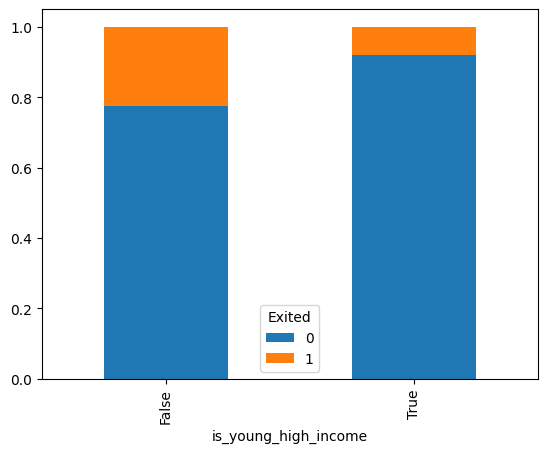

In [85]:
pd.crosstab(df["is_young_high_income"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)


In [86]:
df["ratio_salary_Age"] = (df["EstimatedSalary"] +1e-5) / df["Age"]

In [87]:
df.groupby("Exited")["ratio_salary_Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,3206.537801,1617.617882,0.222692,1999.216383,3166.408572,4346.122250,11077.247223
1,30450.0,2720.065200,1377.947351,0.269303,1701.777779,2693.574334,3616.195504,10962.340556


<Axes: xlabel='Exited'>

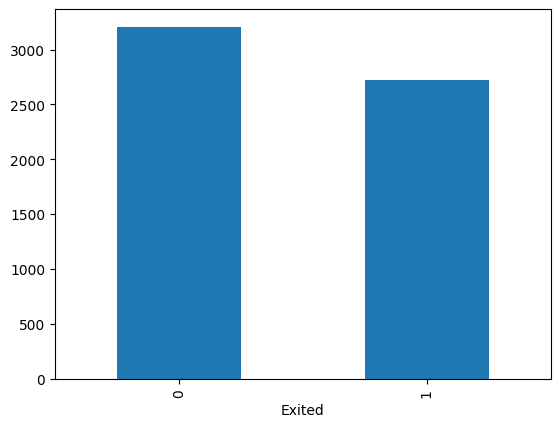

In [88]:
df.groupby("Exited")["ratio_salary_Age"].mean().plot(kind="bar")

In [89]:
df["is_active_creditCard"] = (df["HasCrCard"] == 1) & (df["IsActiveMember"] == 1)

<Axes: xlabel='is_active_creditCard'>

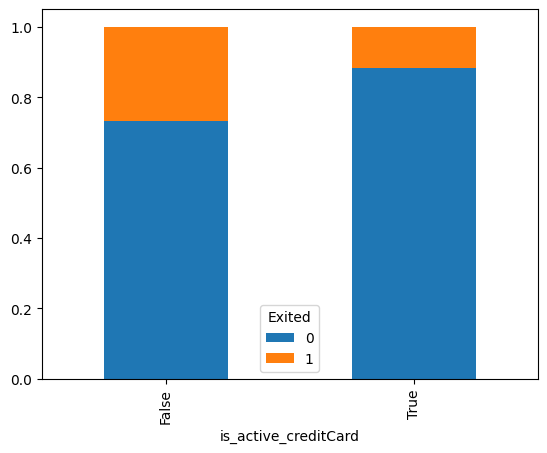

In [90]:
pd.crosstab(df["is_active_creditCard"], df["Exited"], normalize="index").plot(kind="bar", stacked=True)